In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ALLCools.plot import *
from ALLCools.dmr.dmr_lineage_plot import *

from sklearn.cluster import SpectralBiclustering

## RC

In [11]:
from matplotlib import rc

labelsize = 4.5
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

In [12]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

## Read Data

In [13]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

cell_tidy_data = cell_tidy_data[cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

In [14]:
brain_region_df = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/BrainRegion.txt',
    sep='\t',
    index_col=0)

region_name_order = [
    'ORB', 'PFC-1', 'PFC-2', 'ACA-1', 'ACA-2', 'ACA-3', 'AI', 'MOp-1', 'MOp-2',
    'MOp-3', 'MOp-4', 'MOs-1', 'MOs-2', 'MOs-3', 'SSp-1', 'SSp-2', 'SSp-3',
    'SSp-4', 'SSp-5', 'SSs-1', 'SSs-2', 'CA-i', 'CA-ii', 'CA-iii', 'CA-iv',
    'DG-1', 'DG-2', 'DG-3', 'DG-4', 'MOB', 'AON', 'PIR-1', 'PIR-2', 'PIR-3',
    'PIR-4', 'PIR-5', 'CP-1', 'CP-2', 'ACB-1', 'ACB-2', 'ACB-3', 'LSX-1',
    'LSX-2', 'PAL-1', 'PAL-2'
]

brain_region_df = brain_region_df.set_index('RegionName').reindex(
    region_name_order).reset_index()

## Get Dot Plot Data

In [15]:
row_name = 'SubType'
col_name = 'Region'
hue = 'SubType'
palette = sub_type_palette

In [16]:
row_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/order/SubType.order.txt',
    index_col=0,
    header=None).index.tolist()[::-1]
col_order = brain_region_df['DissectionRegion'].tolist()

In [32]:
count = cell_tidy_data.groupby(row_name)[col_name].value_counts()
count.name = 'size'
count_df = count.unstack().fillna(0)
rate_df = count_df / count_df.sum(axis=1).values[:, None]
rate = rate_df.unstack()
rate.name = 'size'

data = rate.reset_index()
data['x'] = data[col_name].apply(lambda i: col_order.index(i))
data['y'] = data[row_name].apply(lambda i: row_order.index(i))
data = data[data['size'] != 0]

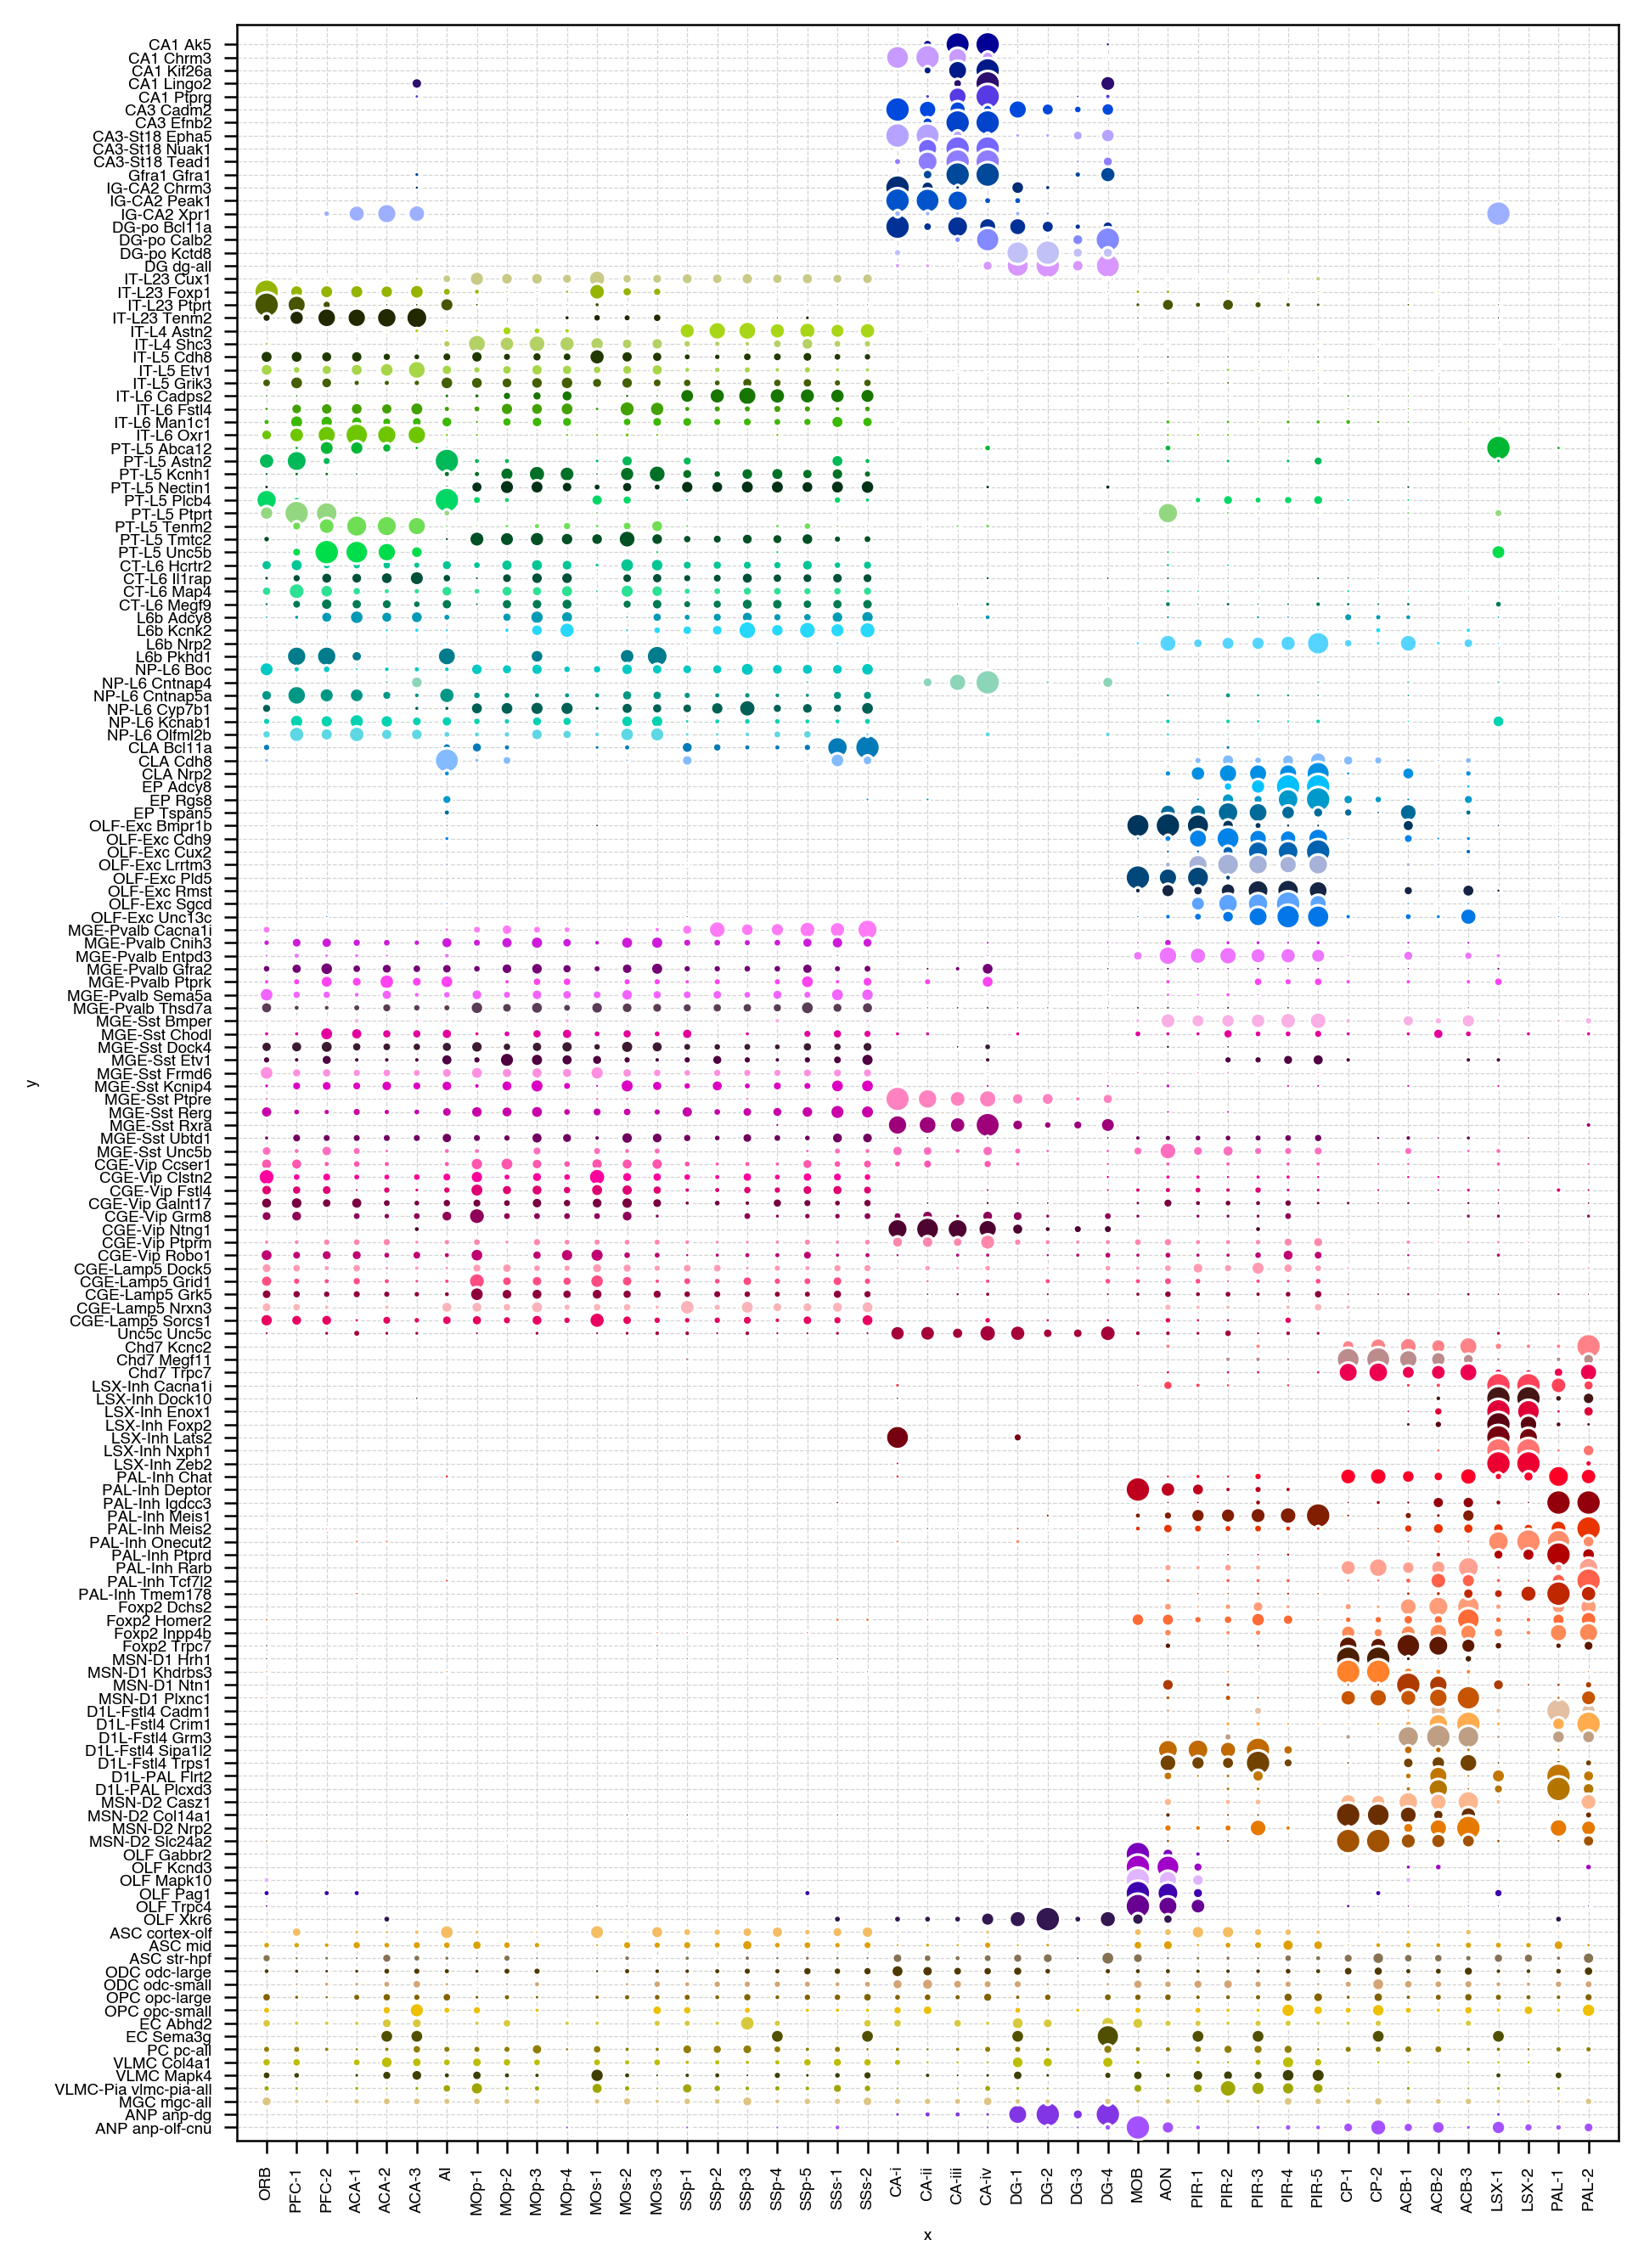

In [33]:
fig, ax = plt.subplots(figsize=(7, 11), dpi=300)

sns.scatterplot(ax=ax,
                data=data,
                x='x',
                y='y',
                hue=hue,
                palette=palette,
                size='size',
                sizes=(1, 50),
                size_norm=(0, 0.3),
                zorder=10)

ax.legend_.set_visible(False)

ax.set(yticks=range(len(row_order)),
       yticklabels=row_order,
       xticks=range(len(col_order)),
       xticklabels=region_name_order,
       ylim=(-1, len(row_order) + 0.5),
       xlim=(-1, len(col_order)))
ax.grid(linewidth=0.3, linestyle='--', c='lightgray')

ax.xaxis.set_tick_params(rotation=90)

pass

In [34]:
data = data.set_index(['x', 'y'])['size'].unstack().fillna(0).values
data.shape

(45, 161)

Text(0.5, 1.05, 'Checkerboard structure of rearranged data')

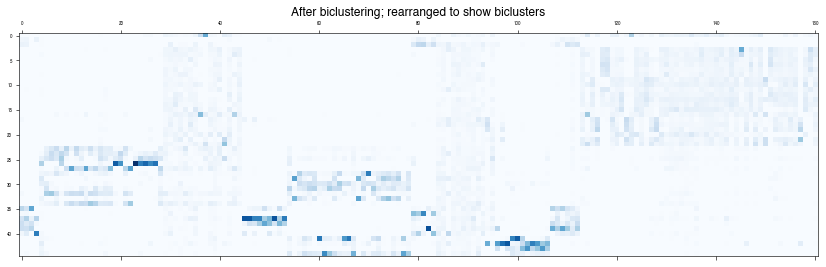

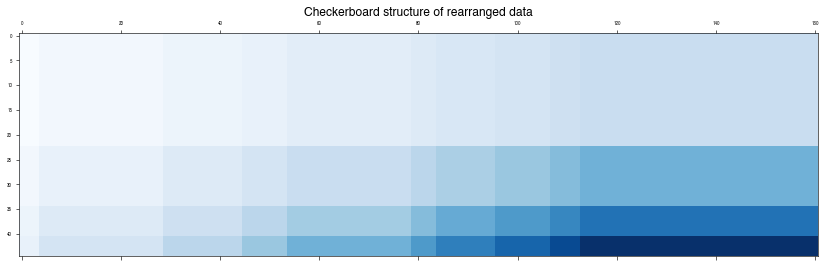

In [43]:
n_clusters = (4, 10)

model = SpectralBiclustering(
    n_clusters=n_clusters,
    method='bistochastic',
    n_components=6,
    n_best=3,
    svd_method='randomized',
    n_svd_vecs=None,
    mini_batch=False,
    init='k-means++',
    n_init=10,
    n_jobs=None,
    random_state=None)
model.fit(data)

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")


Text(0.5, 1.05, 'Checkerboard structure of rearranged data')

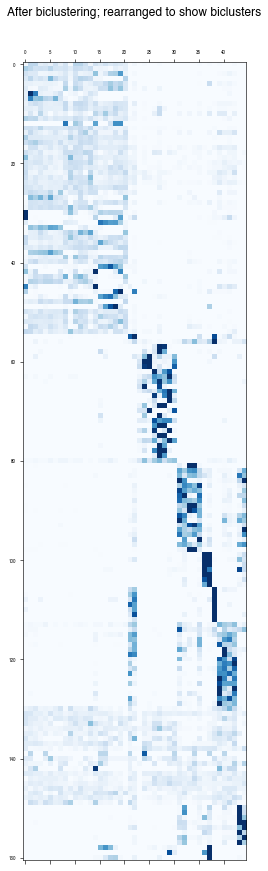

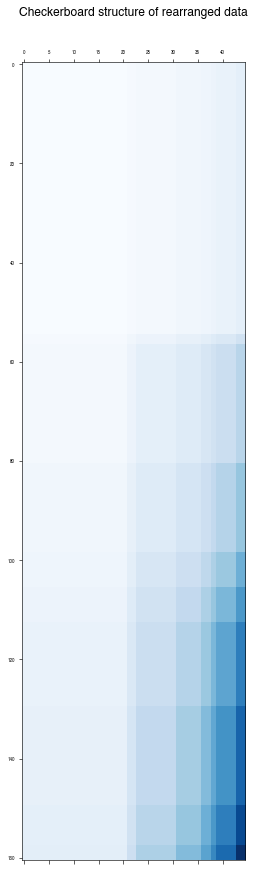

In [59]:
n_clusters = (4, 10)

model = SpectralCoclustering(
    n_clusters=10,
    svd_method='randomized',
    n_svd_vecs=None,
    mini_batch=False,
    init='k-means++',
    n_init=10,
    n_jobs=None,
    random_state=None,)
model.fit(data.T)

fit_data = data.T[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues, vmin=0, vmax=0.3)
plt.title("After biclustering; rearranged to show biclusters")

plt.matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")


In [46]:
data.shape

(45, 161)